# Latent Semantics Indexing

In this notebook, we took a deep-dive of the data by localizing dataset into subgroups with seed comments (feature positive and toxic) and comments that are neighboring in meaning.

In [0]:
# Mount google drive
# Colab initialization
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd /content/drive/My\ Drive/ResponsibleDSProject

In [0]:
!pip install gensim

In [0]:
!pip install spacy

In [0]:
import pandas as pd
import gensim
from gensim import corpora
from collections import defaultdict

In [0]:
tp_csv=pd.read_csv('./test_public_expanded.csv')

In [0]:
submission_csv=pd.read_csv('./submission.csv')

## Tokenization

We perform a reasonable English-language tokenization with Spacy library

In [0]:
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [0]:
tokens=[tokenizer(t) for t in tp_csv['comment_text']]

In [0]:
texts=[[str(t) for t in tt] for tt in tokens]

## Build BoW

In [0]:
dictionary = corpora.Dictionary(texts)

In [0]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [0]:
import pickle

In [0]:
pickle.dump(corpus, open('./corpus.p', mode='wb'))

## Build LSI

In [0]:
from gensim import models
# lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=100)
lsi = models.LsiModel.load('./test_public.lsi')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from gensim import similarities
# index = similarities.MatrixSimilarity(lsi[corpus])
index = similarities.MatrixSimilarity.load('./test_public_lsi.index')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# index.save('./test_public_lsi.index')

In [0]:
# lsi.save('./test_public.lsi')

In [0]:
# Find comments similar to comment #4
sorted(enumerate(index[lsi[corpus[4]]]), key=lambda x: -x[1])[:10]

[(4, 1.0),
 (15272, 0.902352),
 (72394, 0.896707),
 (14215, 0.8951077),
 (38752, 0.89465356),
 (55210, 0.89427745),
 (44697, 0.8942518),
 (94837, 0.89416766),
 (11381, 0.89395434),
 (96973, 0.89297175)]

In [0]:
tp_csv['comment_text'][15272]

'SAA is a smaller scale duplicate of south africa. Cader deployment, corrupt leader, tender fraud, dodgy finance deals, huge consultant fees, rotating management, personal enrichment, friends in right places, total incompetence and protection from structures. All in all a lost opportunity never to be made up.'

In [0]:
submission_csv['prediction'][15272]

0.8302916854619979

In [0]:
submission_csv[(submission_csv['prediction']>0.5) & (tp_csv['female'] > 0.5)]

,id,prediction
103,7000103,1.028124
206,7000206,1.022033
323,7000323,0.507464
387,7000387,1.793566
401,7000401,1.793887
...,...,...
96833,7096833,1.463537
96836,7096836,0.656292
96911,7096911,1.894577
97122,7097122,0.969890


## Take a look at sample result of similairty

In [0]:
sorted(enumerate(index[lsi[corpus[96833]]]), key=lambda x: -x[1])[:10]

[(96833, 1.0000002),
 (18928, 0.94458133),
 (9349, 0.93294656),
 (72730, 0.93000424),
 (84210, 0.9226103),
 (49854, 0.9159316),
 (53357, 0.9152851),
 (67705, 0.9141499),
 (11213, 0.910691),
 (47842, 0.91062266)]

In [0]:
for (i, sim) in sorted(enumerate(index[lsi[corpus[96833]]]), key=lambda x: -x[1])[:10]:
    print(tp_csv['id'][i], i, tp_csv['comment_text'][i], sim, submission_csv['prediction'][i], tp_csv['female'][i])

7096833 96833 No, I love Queen Elizabeth, she also gave the United States, 1 Acre of Land at Runnymede England. You must not see the difference between certain women, and certain whores. You know, the oldest profession know to mankind. 

Did you read that Opinion from a Real COURT? 
1215 the Magna Charta Property, just in case your missing a Flag.
"John, by the grace of God, king of England, lord of Ireland, duke of Normandy and Aquitaine, and count of Anjou, to the archbishop, bishops, abbots, earls, barons, justiciaries, foresters, sheriffs, stewards, servants, and to all his bailiffs and liege subjects, greetings...."

JFK didn't experience Domestic Violence either? Where the hell did you go to school?

https://www.youtube.com/watch?v=Mp9EBvutfIo 1.0000002 1.4635372877120971 0.6000000000000001
7018928 18928 Lack of sidewalks, lack of adequate sidewalks, lack of protection, lack of shade, cars blowing past, no ROW buffer between the street and the sidewalk, wide street crossings, not

In [0]:
tp_csv.iloc[103]

In [0]:
LSI_SIMILAR_CUTOFF=0.85
NUM_CUTOFF=9

def get_similar_docs(doc_idx):
    return sorted([(i, v) for (i,v) in enumerate(index[lsi[corpus[doc_idx]]]) if v>LSI_SIMILAR_CUTOFF], key=lambda x: -x[1])[:NUM_CUTOFF+1]

In [0]:
all_female_positives=submission_csv[(submission_csv['prediction']>0.5) & (tp_csv['female'] > 0.5)].index

In [0]:
len(all_female_positives)

995

## Build data subset with seed comments + neighboring comments

In [0]:
import tqdm

In [0]:
all_female_sim_doc_idx=[i for p in tqdm.notebook.tqdm(all_female_positives) for (i, _) in get_similar_docs(p)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [0]:
len(all_female_sim_doc_idx)

3254

In [0]:
def protected_similar_docs(protected_category):
    all_protected_positives=submission_csv[(submission_csv['prediction']>0.5) & (tp_csv[protected_category] > 0.5)].index
    all_sim_doc_idx=[i for p in tqdm.notebook.tqdm(all_protected_positives) for (i, _) in get_similar_docs(p)]
    return all_sim_doc_idx

In [0]:
all_male_sim_doc_idx=protected_similar_docs('male')

In [0]:
len(all_male_sim_doc_idx)

3116

In [0]:
all_white_sim_doc_idx=protected_similar_docs('white')

In [0]:
all_black_sim_doc_idx=protected_similar_docs('black')

In [0]:
all_christian_sim_doc_idx=protected_similar_docs('christian')

In [0]:
all_muslim_sim_doc_idx=protected_similar_docs('muslim')

In [0]:
all_jewish_sim_doc_idx=protected_similar_docs('jewish')

In [0]:
pickle.dump(all_female_sim_doc_idx, open('./all_female_sim_doc_idx.p', mode='wb'))

In [0]:
pickle.dump(all_male_sim_doc_idx, open('./all_male_sim_doc_idx.p', mode='wb'))

In [0]:
pickle.dump(all_white_sim_doc_idx, open('./all_white_sim_doc_idx.p', mode='wb'))

In [0]:
pickle.dump(all_black_sim_doc_idx, open('./all_black_sim_doc_idx.p', mode='wb'))

In [0]:
pickle.dump(all_christian_sim_doc_idx, open('./all_christian_sim_doc_idx.p', mode='wb'))

In [0]:
pickle.dump(all_muslim_sim_doc_idx, open('./all_muslim_sim_doc_idx.p', mode='wb'))

In [0]:
pickle.dump(all_jewish_sim_doc_idx, open('./all_jewish_sim_doc_idx.p', mode='wb'))

## Analyze correlation

In [0]:
from scipy.stats.stats import pearsonr 

In [0]:
pearsonr(np.nan_to_num(ts_csv.iloc[list(all_female_sim_doc_idx)]['female']), submission_csv.iloc[list(all_female_sim_doc_idx)]['prediction'])

(0.5241548089013012, 7.398533097611985e-201)

In [0]:
pearsonr(np.nan_to_num(ts_csv['female']), submission_csv['prediction'])

(0.0636377388946802, 7.052652334416386e-88)

In [0]:
len(set(all_female_sim_doc_idx))

2849

In [0]:
def corr(category):
    idx=set(pickle.load(open(f'./all_{category}_sim_doc_idx.p', mode='rb')))
    return pearsonr(np.nan_to_num(ts_csv.iloc[list(all_female_sim_doc_idx)][category]), submission_csv.iloc[list(all_female_sim_doc_idx)]['prediction'])

In [0]:
for c in ['male', 'female', 'white', 'black', 'christian', 'muslim', 'jewish']:
    print(c, corr(c))

male (0.24434206974151151, 5.334698275599568e-40)
female (0.5241548089013012, 7.398533097611985e-201)
white (0.16711264584605362, 2.729815877792574e-19)
black (0.16628819914670226, 4.1022076555762066e-19)
christian (0.007912226888046364, 0.672919554304298)
muslim (0.1473211270666395, 2.7200176844588635e-15)
jewish (0.046412233327264504, 0.013228844004021642)


In [0]:
CATEGORIES=['male', 'female', 'white', 'black', 'christian', 'muslim', 'jewish']

In [0]:
c_to_corrs={v: corr(v) for v in CATEGORIES}

In [0]:
c_to_corrs

{'black': (0.16628819914670226, 4.1022076555762066e-19),
 'christian': (0.007912226888046364, 0.672919554304298),
 'female': (0.5241548089013012, 7.398533097611985e-201),
 'jewish': (0.046412233327264504, 0.013228844004021642),
 'male': (0.24434206974151151, 5.334698275599568e-40),
 'muslim': (0.1473211270666395, 2.7200176844588635e-15),
 'white': (0.16711264584605362, 2.729815877792574e-19)}

In [0]:
c_to_corrs.keys()

dict_keys(['male', 'female', 'white', 'black', 'christian', 'muslim', 'jewish'])

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

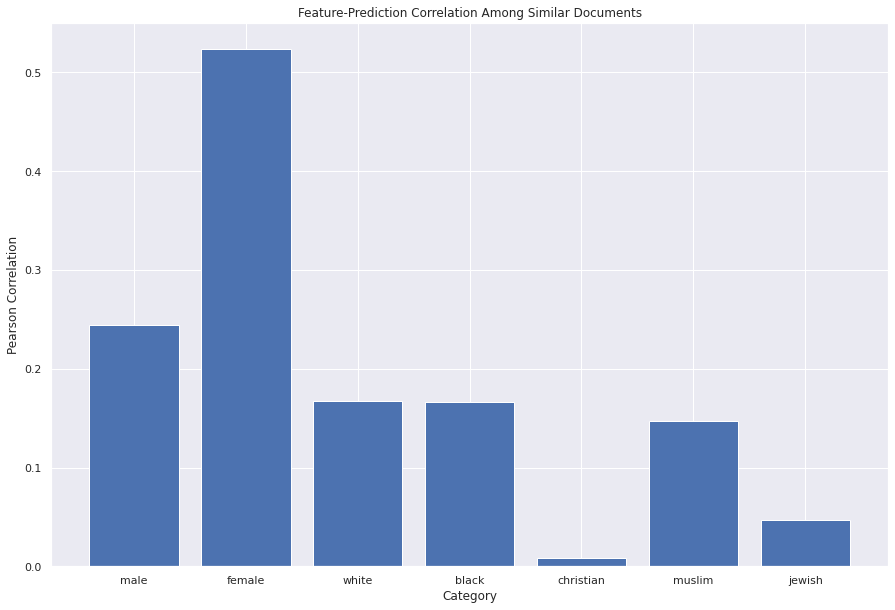

In [0]:
plt.figure(figsize=(15,10))
plt.bar(x=c_to_corrs.keys(), height=pd.DataFrame.from_dict(c_to_corrs).iloc[0])
plt.xlabel('Category')
plt.ylabel('Pearson Correlation')
plt.title('Feature-Prediction Correlation Among Similar Documents')
plt.show()

In [0]:
print("category,toxic_docs,all_similar_docs")
for c in CATEGORIES:
    idx=set(pickle.load(open(f'./all_{c}_sim_doc_idx.p', mode='rb')))
    print(f"{c},{len(submission_csv[(submission_csv['prediction']>0.5) & (ts_csv[c]>0.5)])},{len(set(idx))}")

category,toxic_docs,all_similar_docs
male,929,2764
female,995,2849
white,1013,3102
black,605,1895
christian,642,2257
muslim,676,2096
jewish,225,743
